In [1]:
import cv2
import numpy as np
import os 

from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from scipy import ndimage
from scipy.signal import find_peaks

from IPython.display import clear_output
from PIL import Image

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff, rectMask, mergeMasks
from pepe.preprocess import cannyEdgeDetection, laplacianEdgeDetection, sobelEdgeDetection, applyFilter

from pepe.analysis import gSquared
from pepe.tracking import houghCircle, kernelFind, circularKernelFind, convCircle
from pepe.topology import findPeaks1D, findPeaksMulti, findPeaks2D

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

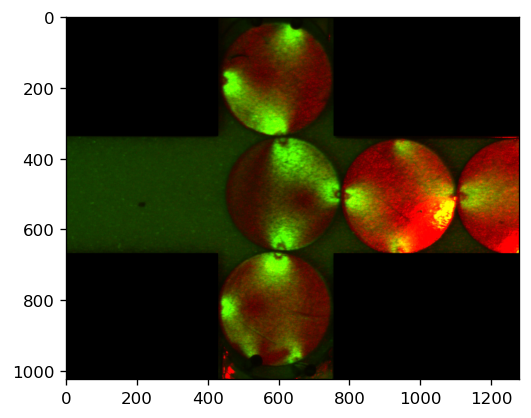

In [2]:
dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'

image = checkImageType(dataFolder + '2022-02-02_Wide/frame0170.bmp')
# Create a cross-shaped channel, with some parts on the ends
# For light correction, we want two separate images, one vertical and one horizontal
maskXBounds = [430, 755] # Found manually
maskYBounds = [338, 668] # Found manually
maskArr = crossMask(image.shape, xlim=np.array(maskXBounds), ylim=np.array(maskYBounds))

plt.imshow(image*maskArr)
plt.show()

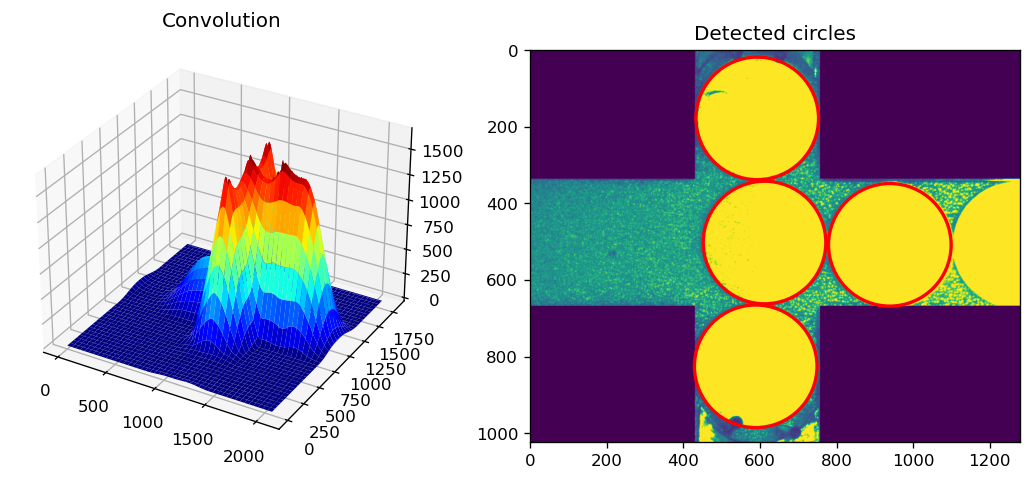

In [3]:
#%matplotlib
radius = 160
particleCenters, particleRadii = convCircle(image[:,:,0]*maskArr[:,:,0], radius,
                                            draw=True, intensitySoftmax=1.2, peakDownsample=15,
                                            offscreenParticles=True, radiusTolerance=None)

In [34]:
%timeit convCircle(image[:,:,0]*maskArr[:,:,0], radius, intensitySoftmax=2., peakDownsample=10)

351 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit houghCircle(image[:,:,0]*maskArr[:,:,0], 155, radiusTolerance=20, draw=False, edgeDetection=None, accumulatorThreshold=22, cannyEdgeThreshold=90)

404 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit circularKernelFind((image[:,:,0]*maskArr[:,:,0])[:50,:50], 30, debug=False, fftPadding=1)

1.02 ms ± 6.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


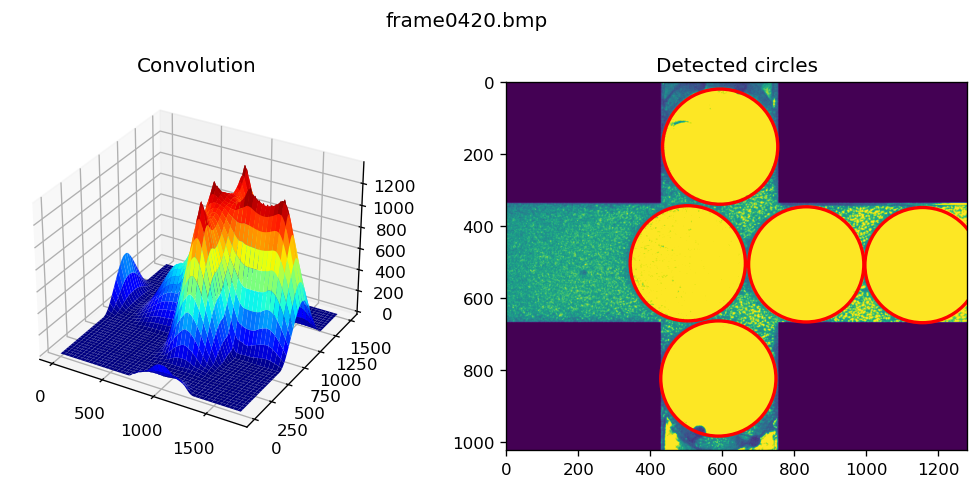

In [5]:
dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
files = os.listdir(dataFolder + '2022-02-02_Wide/')
radius = 160
files = np.sort(files)

# Cut down to only the first hundred
#files = files[:100]

for i in range(len(files)):
    image = checkImageType(dataFolder + '2022-02-02_Wide/' + files[i])
    
    clear_output(wait=True)
    particleCenters, particleRadii = convCircle(image[:,:,0]*maskArr[:,:,0], radius,
                                                draw=True, intensitySoftmax=1.2, peakDownsample=8,
                                                offscreenParticles=False, radiusTolerance=None)
    fig = plt.gcf()
    fig.suptitle(files[i])
    fig.tight_layout()
    plt.savefig('../images/convolution_test/' + files[i][:-4] + '.png')
    plt.show()
    
imageFiles = os.listdir('../images/convolution_test/')
imageFiles = np.sort(imageFiles)
imageFiles = [img for img in imageFiles if img[-3:] == 'png']
fps = 40

images = [None for i in range(len(imageFiles))]
for i in range(len(imageFiles)):
    images[i] = Image.open('../images/convolution_test/' + imageFiles[i])
    
images[0].save('../images/convolution_test/convolution.gif', save_all=True, append_images=images[1:], duration=fps, optimize=False, loop=1)

In [7]:
imageFiles = os.listdir('../images/convolution_test/')
imageFiles = np.sort(imageFiles)
imageFiles = [img for img in imageFiles if img[-3:] == 'png']
fps = 40

images = [None for i in range(len(imageFiles))]
for i in range(len(imageFiles)):
    images[i] = Image.open('../images/convolution_test/' + imageFiles[i])
    
images[0].save('../images/convolution_test/convolution.gif', save_all=True, append_images=images[1:], duration=fps, optimize=False, loop=1)

## Old Stuff

In [2]:
import itertools
import numba

def _iterNeighbors(p, tShape, neighborInclusion=1):
    """
    Find the indices of all neighbors of an `d`-dimensional point.

    Parameters
    ----------

    p : tuple[d]
        A tuple of indices representing a point in $Z^d$.

    tShape : tuple[d]
        The size of the grid/tensor in each dimension, such that
        points outside of the domain can be removed.
    """
    d = len(p)
    # Convert to numpy array to do math (which can't be done on tuples)
    nP = np.array(p, dtype=np.int16)
    neighborDirections = np.arange(-neighborInclusion, neighborInclusion+1, dtype=np.int16)
        
    # Now find the combinations based on the possible values
    neighbors = []
    result = [[np.int64(0) for i in range(0)]]
    
    for pool in [neighborDirections]*d:
        result = [x+[y] for x in result for y in pool]
        
    neighbors = [nP + np.array(n) for n in result]
    
    # This element will always be the original point
    del neighbors[len(neighbors)//2]
    
    checkedNeighbors = []
    for n in neighbors:
        if not True in ((np.array(tShape) - n - 1) < 0) and not True in (n < 0):
            checkedNeighbors.append(tuple(n))
    
    return checkedNeighbors

_iterNeighbors((9, 1), (10, 10), 2)

[(7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (9, 0),
 (9, 2),
 (9, 3)]

In [245]:
a = np.array([1, 2, 3, 4])
print(True in (a < 0))

False


In [5]:
a = np.array([[[1, 2, 3], [4, 3, 6], [4, 6, 2]], [[8, 3, 5], [1, 4, 6], [1, 4, 2]], [[1, 5, 2], [5, 2, 6], [7, 2, 5]]])
#indices = np.dstack(np.unravel_index(np.argsort(a.flatten())[::-1], a.shape))[0]
#indices = [tuple(si) for si in indices]
#a[((indices[1]), (indices[0]))]
np.unravel_index(np.argmax(a.flatten()), a.shape)

(1, 0, 0)

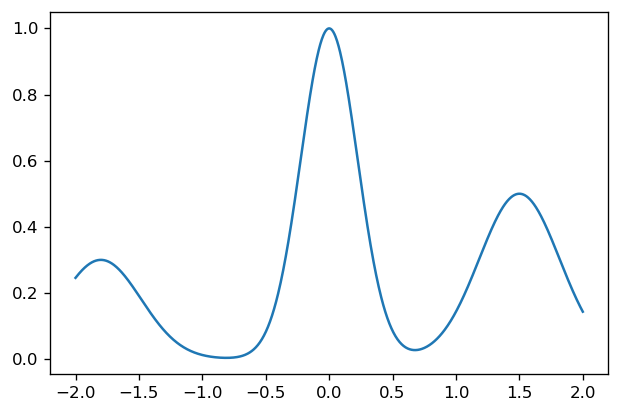

/home/jack/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  if __name__ == '__main__':


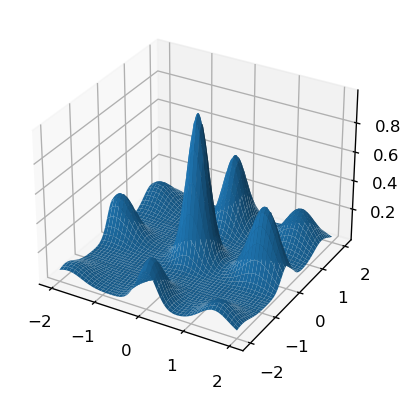

In [7]:
xArr = np.linspace(-2, 2, 1000)
data = np.exp(-xArr**2*10) + .5*np.exp(-5*(xArr-1.5)**2) + .3*np.exp(-5*(xArr+1.8)**2)# + .7*np.exp(-10*(xArr+.6)**2)
data2d = np.multiply.outer(data, data)

plt.plot(xArr, data)
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xArr, np.vstack(xArr), data2d)
plt.show()

In [3]:
class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]

def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key = lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)

In [4]:
findPeaks(data)

(array([50, 87,  5]), array([1.        , 0.47481915, 0.29786045]))

In [ ]:
findPeaks2D(data2d)

In [15]:
%timeit get_persistent_homology(data)

6.21 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
def genTrainingImages(imgSize, N, minCircles=1, maxCircles=4, minRadius=125, maxRadius=200, overlap=False, noise=1):
    img = np.zeros((N, *imgSize))
    numCircles = np.random.randint(minCircles, maxCircles, size=N)
    
    circleCentersX = np.random.randint(0, imgSize[0], size=N)
    circleCentersY = np.random.randint(0, imgSize[1], size=N)
    
    Y = np.arange(imgSize[0]).reshape((imgSize[0], 1)) # Column vector
    X = np.arange(imgSize[1]).reshape((1, imgSize[1])) # Row vector
    
    # Generate the circles
    for i in range(N):
        radii = np.random.uniform(minRadius, maxRadius, size=numCircles[i])
        j = 0
        while j < numCircles[i]:
            yC, xC = np.random.randint(0, imgSize[0]), np.random.randint(0, imgSize[1])
            newCircle = ((X - xC)**2 + (Y - yC)**2) < radii[j]**2
            # Make sure circles don't overlap
            if np.max(img[i] + newCircle) == 1:
                img[i] += newCircle
                j += 1
                
    # Now add noise
    noisyImg = img + np.random.uniform(0.01*noise, noise, size=img.shape)
    
    return noisyImg, img, (yC, xC)

In [23]:
noisyImg, img, center = genTrainingImages((1024, 1280), 1, minCircles=1, maxCircles=3, noise=3, minRadius=150, maxRadius=150)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(img[0])
ax[1].imshow(noisyImg[0])
plt.savefig('test_img.png')
plt.show()

print(center)

(547, 558)


In [24]:
radius = 150
costArr = circularKernelFind(noisyImg[0], 150, debug=True, fftPadding=300)
maxPoints = np.where(costArr == np.max(costArr))
maxPoints = (maxPoints[0][0], maxPoints[1][0])
#costArr = convCircle(image[:,:,0]*maskArr[:,:,0], radius, fftPadding=1)

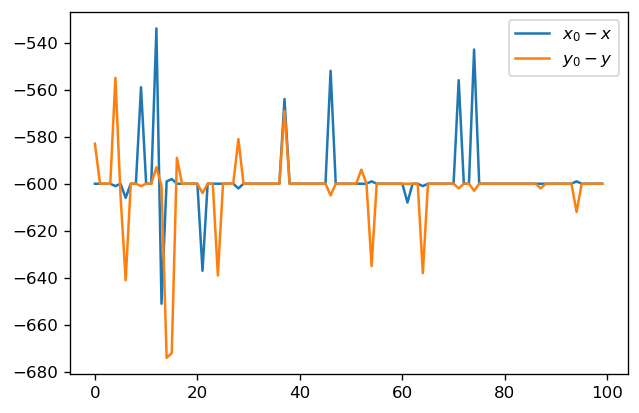

In [6]:
xDiffArr = np.zeros(100)
yDiffArr = np.zeros(100)

radius = 150

for i in range(100):
    noisyImg, img, center = genTrainingImages((1024, 1280), 1, minCircles=1, maxCircles=2, noise=5, minRadius=150, maxRadius=150)
    costArr = circularKernelFind(noisyImg[0], radius, debug=False, fftPadding=int(radius*3))
    maxPoint = np.where(costArr == np.max(costArr))
    maxPoint = (maxPoint[0][0], maxPoint[1][0])
    
    yDiffArr[i] = center[0] - maxPoint[0]
    xDiffArr[i] = center[1] - maxPoint[1]
    
plt.plot(yDiffArr, label='$x_0 - x$')
plt.plot(xDiffArr, label='$y_0 - y$')
plt.legend()
plt.savefig('offset.png')
plt.show()

In [26]:
plt.imshow(np.abs(costArr))

In [31]:
peakDownsample = 10

downsampledConvArr = cv2.resize(cv2.blur(np.abs(costArr), (peakDownsample,peakDownsample)),
                                     (0,0), fx=1/peakDownsample, fy=1/peakDownsample, interpolation=cv2.INTER_CUBIC)

In [32]:
plt.imshow(downsampledConvArr)

In [33]:
ax = plt.subplot(projection='3d')
ax.plot_surface(np.arange(downsampledConvArr.shape[1]), np.vstack(np.arange(downsampledConvArr.shape[0])), downsampledConvArr)
plt.show()

In [19]:
#%matplotlib qt
%matplotlib
ax = plt.subplot(projection='3d')
ax.plot_surface(np.arange(costArr.shape[1]), np.vstack(np.arange(costArr.shape[0])), costArr)
plt.show()

Using matplotlib backend: QtAgg


In [25]:
peakLocations, peakPrevalences = findPeaks2D(np.abs(costArr[::6,::6]), minPeakPrevalence=.6)
peakLocations = [[p[0]*6 - 3*radius, p[1]*6 - 3*radius] for p in peakLocations]
peakLocations

[[546, 558]]

In [15]:
np.where(costArr == np.max(costArr))

(array([984]), array([1388]))

In [13]:
sys.path.append('/home/jack/workspaces/jupyter-workspace/persistence/')

from imagepers import persistence

In [16]:
%timeit persistence(np.abs(costArr))

41.2 s ± 2.82 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
